In [16]:
import sr_signal
import database
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import product
import math

# This is for jupyter to recognize changes in external files without restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Simulation data
path = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output"
scenarios = ["S7_IRREG1_K1", "S8_IRREG1_K0d7", "S9_IRREG1_K0d5", "S10_IRREG1_K1d35", "S11_IRREG2_K1"]
sensor_locations = ["SRS_B1_WS1_R"]
sensor_names = ["WS1_right"]

fs = 50  # Hz

# segmentation
seg_len_sec = 16.0
seg_hop_sec = 1.6  # 90% overlap
seg_len_samples = int(seg_len_sec * fs)  # 800
seg_hop_samples = int(seg_hop_sec * fs)  # 80

In [3]:
scenario_data = {}

for scenario in scenarios:
    scenario_data[scenario] = sr_signal.load_data(path, scenario)

In [34]:
scenario = "S7_IRREG1_K1"
sensor_name = sensor_names[0]
segment = 32  # max. 65

acceleration, time, dist = scenario_data[scenario][sensor_name]

segments = []  # list of (seg_signal, seg_start_time, seg_index) tuples

N = len(acceleration)
seg_index = 0
start = 0
while start + seg_len_samples <= N:
    end = start + seg_len_samples
    seg_signal = acceleration[start:end]
    seg_start_time = time[start]  # absolute time from simulation start
    segments.append((seg_signal, seg_start_time, seg_index))
    seg_index += 1
    start += seg_hop_samples

seg_signal, seg_start_time, seg_index = segments[segment]

stft_magnitude, peaks, frame_times, freqs = sr_signal.process_signal(seg_signal)

In [35]:
# segment data
print(f'Number of segments per simulation = {len(segments)}, expected = {math.floor((N-seg_len_samples)/seg_hop_samples+1)}')

Number of segments per simulation = 66, expected = 66


In [37]:
# Single frame
window = 3
half_window = window // 2
local_max = np.zeros(len(stft_magnitude), dtype=bool)

for i in range(half_window, len(stft_magnitude) - half_window):
    if stft_magnitude[i] == np.max(stft_magnitude[i-half_window:i+half_window+1]) and stft_magnitude[i] > 0:
        local_max[i] = True

fig, ax = plt.subplots()

ax.plot(freqs, stft_magnitude)
ax.scatter(freqs[local_max], stft_magnitude[local_max])

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude")

plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

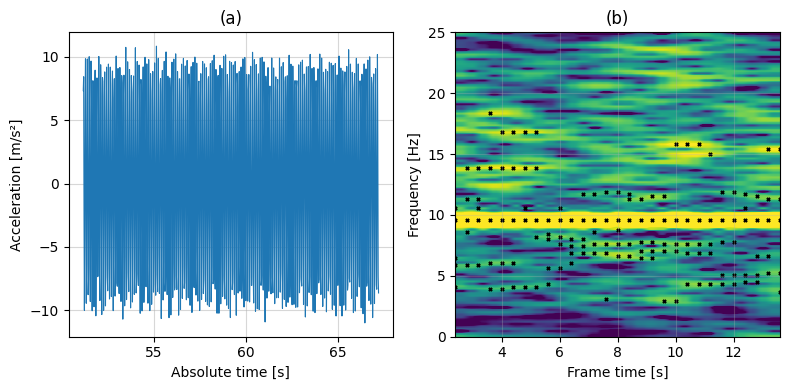

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

seg_time = seg_start_time + np.arange(seg_len_samples) * (time[1] - time[0])

ax1.plot(seg_time, seg_signal, linewidth=0.8)
ax1.set_ylabel("Acceleration [m/s²]")
ax1.set_xlabel("Absolute time [s]")
ax1.set_title("(a)")
ax1.grid(True, alpha=0.5)

mag_db = 10 * np.log10(stft_magnitude + 1e-12)  # prevent taking the log of zero (infinite magnitude for lg(0))
vmin = np.percentile(mag_db, 5)
vmax = np.percentile(mag_db, 95)
im = ax2.imshow(
    mag_db,
    aspect="auto",
    origin="lower",
    extent=[frame_times[0], frame_times[-1], freqs[0], freqs[-1]],
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

peak_freqs = np.array([p[0] for p in peaks])
peak_times = np.array([p[1] for p in peaks])
ax2.scatter(peak_times, peak_freqs, marker='x', s=5, color='black')
#
# # Horizontal lines for resonant modes
# for i in range(4):
#     for freq, label in mode_annotations.get(sensor_names[i], []):
#         ax2.axhline(freq, color="red", linestyle="--", linewidth=0.8, alpha=0.8)
#
#         # label on the right side of the spectrogram
#         ax2.text(
#             0.99, freq,
#             label,
#             transform=ax2.get_yaxis_transform(),  # x in axes coords, y in data coords
#             ha="right",
#             va="bottom",
#             fontsize=9,
#             color="red",
#             backgroundcolor="white",
#             alpha=0.8,
#         )

ax2.set_xlabel("Frame time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("(b)")
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# Single frame
frame_idx = 80
frame = stft_results[sensor_names[2]]["stft_magnitude"][:, frame_idx]

window = 3
half_window = window // 2
local_max = np.zeros(len(frame), dtype=bool)

for i in range(half_window, len(frame) - half_window):
    if frame[i] == np.max(frame[i-half_window:i+half_window+1]) and frame[i] > 0:
        local_max[i] = True

fig, ax = plt.subplots()

ax.plot(freqs, frame)
ax.scatter(freqs[local_max], frame[local_max])

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude")

plt.show()